In [2]:
%matplotlib inline
#posteior distribution of binomial data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits
import scipy.special as special

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 


def loadData(filename):
    '''
    Read fits data
    
    '''
    tchfits = fits.open(filename)
    tabl = tchfits[1].data
    return tabl

# star/galaxy ratio in a small field of sky
filename = 'sdss_field.fits'
sdss = loadData(filename)

types = sdss.type
J = 13
#
observs = np.zeros((J,2))
for j in range(J):
    t0 = types[(j*50):np.min([(j*50+50),len(types)])]    
    observs[j,:] = np.array([np.float(np.sum(t0==3)),len(t0)])
    print 'No.%(d0)d: N_star=%(d1).0f, N_all=%(d2)d\n' %\
        {'d0':j,'d1':observs[j,0],'d2':observs[j,1]}


No.0: N_star=28, N_all=50

No.1: N_star=33, N_all=50

No.2: N_star=31, N_all=50

No.3: N_star=34, N_all=50

No.4: N_star=39, N_all=50

No.5: N_star=32, N_all=50

No.6: N_star=40, N_all=50

No.7: N_star=33, N_all=50

No.8: N_star=29, N_all=50

No.9: N_star=32, N_all=50

No.10: N_star=26, N_all=50

No.11: N_star=34, N_all=50

No.12: N_star=26, N_all=43



In [3]:
#point estimate
E_theta = np.mean(observs[:-1,0]/observs[:-1,1])
D_theta = np.var(observs[:-1,0]/observs[:-1,1])
print 'point estimates using the first 12 observations'
print 'E(theta)=%(e).5f,\tD(theta)=%(v).5f' %\
    {'e':E_theta, 'v':D_theta}

beta = (E_theta*(1-E_theta)/D_theta-1)*(1-E_theta)
alpha = E_theta*beta/(1-E_theta)
print '\nEstimates for the parameters of the prior density'
print 'alpha=%(a).5f,\tbeta=%(b).5f' % {'a':alpha, 'b':beta}

point estimates using the first 12 observations
E(theta)=0.65167,	D(theta)=0.00603

Estimates for the parameters of the prior density
alpha=23.87784,	beta=12.76334


Parameters of te posterior density
E(theta)=0.62628,	stD(theta)=0.05387


/Users/cliu/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


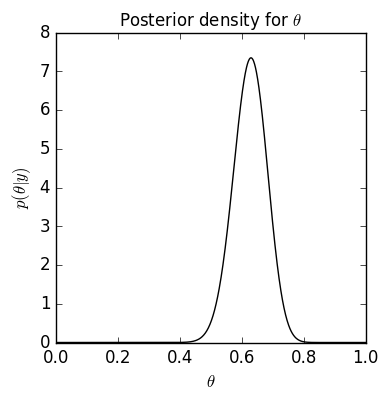

In [4]:
y = observs[-1,0]
n = observs[-1,1]
alpha_post = alpha+y
beta_post = beta+n-y
E_theta_post = alpha_post/(alpha_post+beta_post)
D_theta_post = alpha_post*beta_post/\
    ((alpha_post+beta_post)**2*(alpha_post+beta_post+1))
print 'Parameters of te posterior density'
print'E(theta)=%(e).5f,\tstD(theta)=%(v).5f' % \
    {'e':E_theta_post, 'v':np.sqrt(D_theta_post)}
theta = np.arange(0,1,0.001)
p = stats.beta.pdf(theta,alpha_post, beta_post)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(theta,p,'k-')
ax.set_xlabel(r'$\theta$',fontsize=12)
ax.set_ylabel(r'$p(\theta|y)$',fontsize=12)
ax.set_title(r'Posterior density for $\theta$',fontsize=12)
fig.show()

In [5]:
print np.log(alpha/beta),np.log(alpha+beta)

0.626373308021 3.60117272215


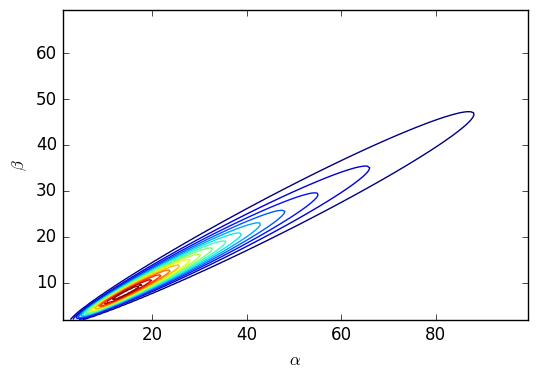

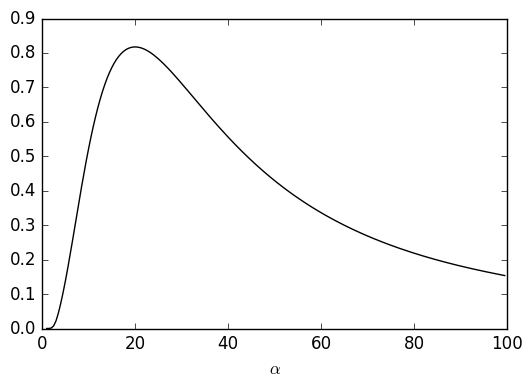

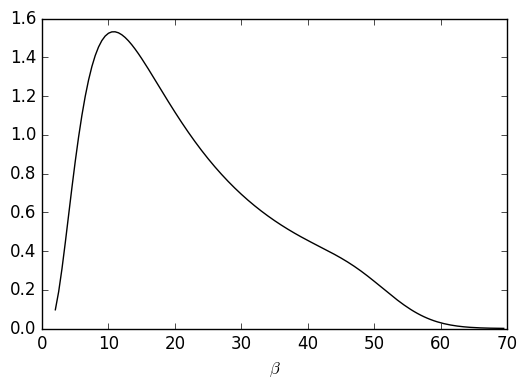

In [7]:
#Bayesian model
def posteriorln(x,y,n):
    alpha = x[0]
    beta = x[1]
    lnlikeli = 0.
    for j in range(len(y)):
        lnlikeli += special.gammaln(alpha+beta)+\
            special.gammaln(alpha+y[j])+\
            special.gammaln(beta+n[j]-y[j])-\
            special.gammaln(alpha)-special.gammaln(beta)-\
            special.gammaln(alpha+beta+n[j])
    priorln = -5./2.*np.log(alpha+beta)
    return lnlikeli+priorln+395.

def draw_posterior(y,n,alphagrid,betagrid):
    p = np.zeros((len(alphagrid),len(betagrid)))
    for i in range(len(alphagrid)):
        for j in range(len(betagrid)):
            p[i,j] = posteriorln([alphagrid[i],betagrid[j]],y,n)
    return p



alphagrid = np.arange(1,100,0.5)
betagrid = np.arange(2,70,0.5)
p = draw_posterior(observs[:-1,0],observs[:-1,1],\
        alphagrid,betagrid)

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.contour(amesh, bmesh, np.exp(p.T),20,\
            extent=[alphagrid[0],\
            alphagrid[-1],betagrid[0],betagrid[-1]])
ax.set_xlabel(r'$\alpha$',fontsize=12)
ax.set_ylabel(r'$\beta$',fontsize=12)

fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.plot(alphagrid, np.sum(np.exp(p), axis=1),'k-')
ax.set_xlabel(r'$\alpha$',fontsize=12)

fig.show()
        
fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.plot(betagrid, np.sum(np.exp(p), axis=0),'k-')
ax.set_xlabel(r'$\beta$',fontsize=12)

fig.show()

In [93]:
np.max(p)
np.log(25+14)

3.6635616461296463

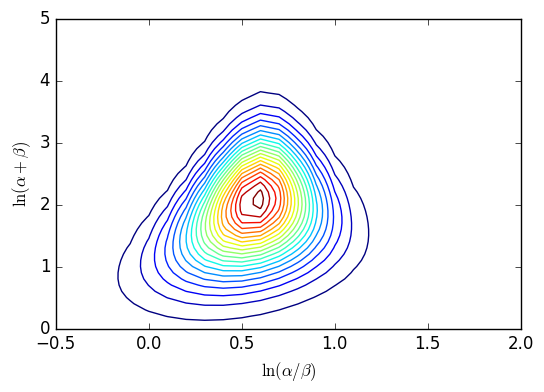

In [8]:
def draw_posteriorln(y,n,agrid,bgrid):
    p = np.zeros((len(agrid),len(bgrid)))
    for i in range(len(agrid)):
        for j in range(len(bgrid)):
            alpha = np.exp(agrid[i]+bgrid[j])/(1+np.exp(agrid[i]))
            beta = np.exp(bgrid[j])/(1+np.exp(agrid[i]))
            #print alpha,beta
            Jacob_detln = -np.log(alpha)-np.log(beta)
            p[i,j] = posteriorln([alpha,beta],y,n)+Jacob_detln
    return p

agrid = np.arange(-0.5,2,0.1)
bgrid = np.arange(0,5,0.1)
p2 = draw_posteriorln(observs[:-1,0],observs[:-1,1],\
        agrid,bgrid)

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(agrid,bgrid)
ax.contour(amesh, bmesh, np.exp(p2.T-7.34),20,\
            extent=[alphagrid[0],\
            alphagrid[-1],betagrid[0],betagrid[-1]])
ax.set_xlim([-0.5,2])
ax.set_ylim([0,5])
ax.set_xlabel(r'$\ln(\alpha/\beta)$',fontsize=12)
ax.set_ylabel(r'$\ln(\alpha+\beta)$',fontsize=12)

fig.show()

mean(alpha|y)=9.17608	mean(beta|y)=5.06795


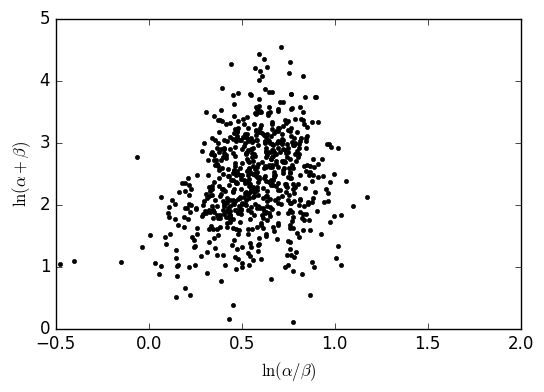

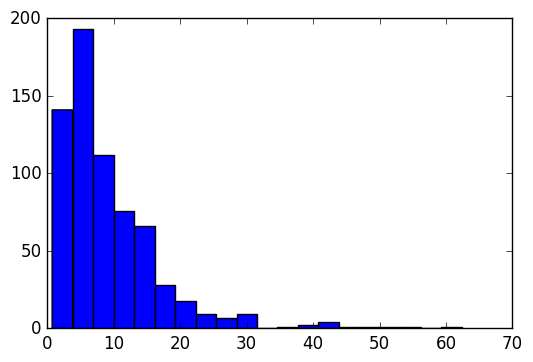

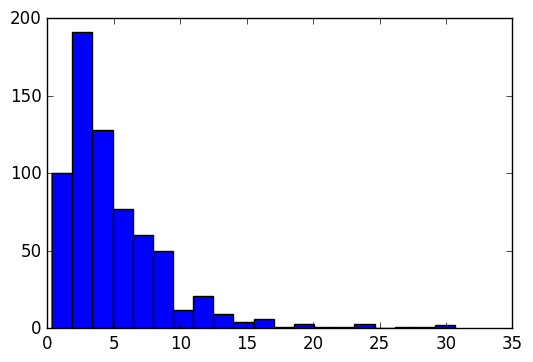

In [137]:
#sample random values from p(ln(a/b),ln(a+b))
N = 10000
a0 = np.random.uniform(-0.5,2,size=N)
b0 = np.random.uniform(0,5,size=N)
p0 = np.random.uniform(0,0.0117,size=N)
alpha0 = np.exp(a0+b0)/(1+np.exp(a0))
beta0 = np.exp(b0)/(1+np.exp(a0))
Jacob_detln = -np.log(alpha0)-np.log(beta0)
p = np.exp([posteriorln([alpha0[i],beta0[i]],\
    observs[:-1,0],observs[:-1,1])+Jacob_detln[i] \
    for i in range(N)])
ind = (p0<=p)
a = a0[ind]
b = b0[ind]
alpha = alpha0[ind]
beta = beta0[ind]

print 'mean(alpha|y)=%(a).5f\tmean(beta|y)=%(b).5f' %\
    {'a': np.mean(alpha),'b': np.mean(beta)}
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(a,b,'k.')
ax.set_xlim([-0.5,2])
ax.set_ylim([0,5])
ax.set_xlabel(r'$\ln(\alpha/\beta)$',fontsize=12)
ax.set_ylabel(r'$\ln(\alpha+\beta)$',fontsize=12)
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(alpha,20)
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(beta,20)
fig.show()


mean(theta|alpha,beta,y)=0.65196
std(theta|alpha,beta,y)=0.01679


/Users/cliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


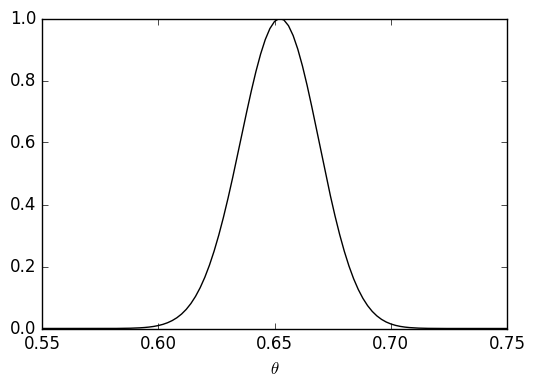

In [149]:
#predict post density of theta
theta = np.arange(0,1,0.002)
pln = np.zeros(np.shape(theta))
for j in range(13):
    a = np.mean(alpha)+observs[j,0]
    b = np.mean(beta)+observs[j,1]-observs[j,0]
    pln = pln+np.log(stats.beta.pdf(theta,a,b))

p = np.exp(pln-np.max(pln))

mean_theta_post = np.sum(p*theta)/np.sum(p)
std_theta_post = np.sqrt(np.sum(p*(theta-\
    mean_theta_post)**2)/np.sum(p))
print 'mean(theta|alpha,beta,y)=%(p).5f' %\
    {'p':mean_theta_post}
print 'std(theta|alpha,beta,y)=%(p).5f' %\
    {'p':std_theta_post}
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta,p,'k-')
ax.set_xlabel(r'$\theta$',fontsize=12)
ax.set_xlim([0.55,0.75])
fig.show()


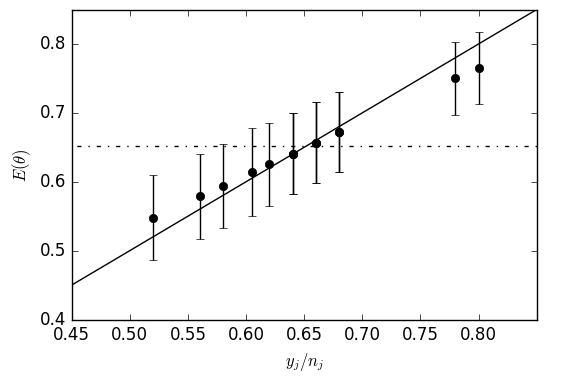

In [148]:

#estimate theta_j from the given mean alpha and beta
p_theta_post = np.zeros((13,2))
for j in range(13):
    a = np.mean(alpha)+observs[j,0]
    b = np.mean(beta)+observs[j,1]-observs[j,0]
    p_theta_post[j,0] = a/(a+b)
    p_theta_post[j,1] =np.sqrt(a*b/((a+b)**2*(a+b+1)))

    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(observs[:,0]/observs[:,1],p_theta_post[:,0],\
    yerr=p_theta_post[:,1],fmt='ko')
ax.plot([0.45,0.85],[0.45,0.85],'-k')
ax.plot([0,1],[mean_theta_post,mean_theta_post],'k-.')
ax.set_xlabel(r'$y_j/n_j$',fontsize=12)
ax.set_ylabel(r'$E(\theta)$',fontsize=12)
ax.set_xlim([0.45,0.85])

fig.show()

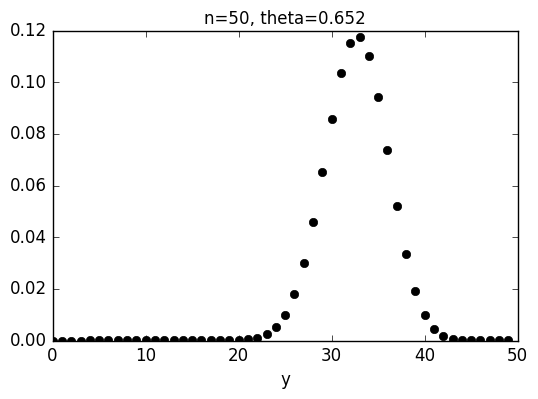

In [156]:
#predict next y from posterior theta
y = np.arange(0,50,1)
p_y = stats.binom.pmf(y,50,mean_theta_post)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y,p_y,'ko')
ax.set_xlabel('y',fontsize=12)
ax.set_title('n=50, theta=%(t).3f' % {'t': mean_theta_post})

fig.show()

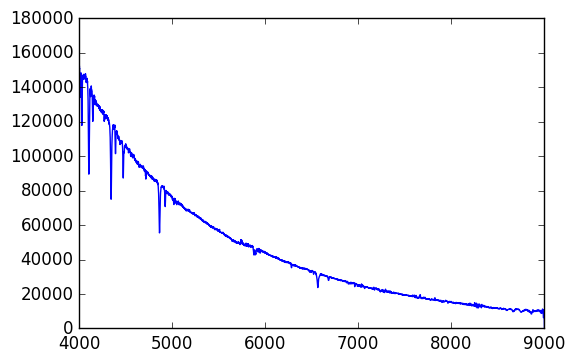

In [9]:
# measure the redshift from an absorption line
filename = '351110104.fits'
tchfits = fits.open(filename)
log_wv0 = tchfits[0].header['CRVAL1']
log_dwv = tchfits[0].header['CD1_1']

sp = tchfits[0].data

N = len(sp[0,:])
wv = 10**(log_wv0+np.arange(0,N,1)*log_dwv)

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
ax.plot(wv,sp[0,:])
ax.set_xlim([4000,9000])
fig.show()


mean vel = -12.262+/-2.286

mean vel = -4.671+/-0.749

mean vel = -10.050+/-2.486

mean vel = -13.026+/-1.865


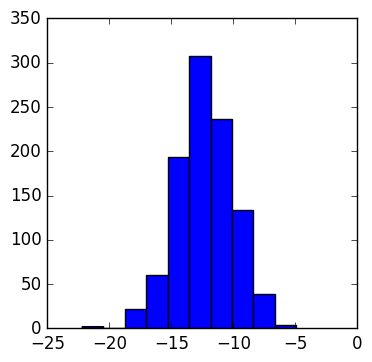

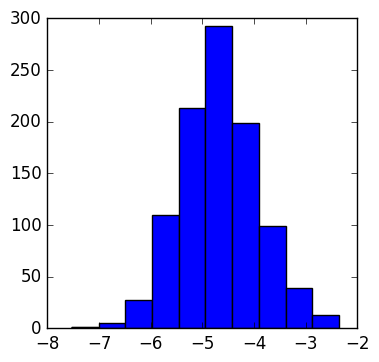

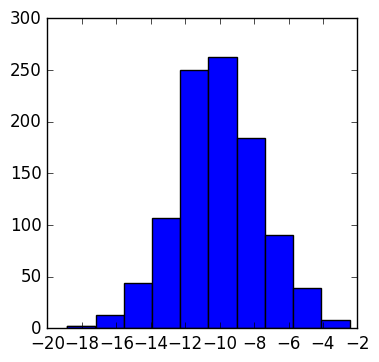

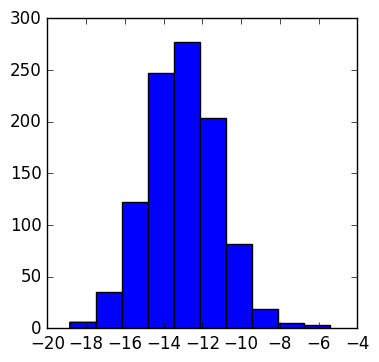

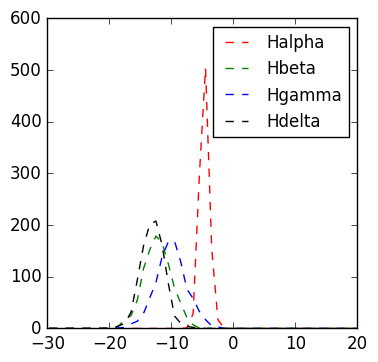

In [13]:
Ha_0 = 6564.6
Hb_0 = 4862.71
Hg_0 = 4341.69
Hd_0 = 4102.89

Ha_cont = [6420.00,6455.00,6600.00,6640.00]
Hb_cont = [4823.875,4847.875,4876.625,4891.625]
Hg_cont = [4283.50,4319.75,4367.25,4419.75]
Hd_cont = [4041.60,4079.75,4128.50,4161.00]

def normSpec(wv,sp,cont):
    ind_cont1 = (wv>=cont[0]) & (wv<=cont[1])
    ind_cont2 = (wv>=cont[2]) & (wv<=cont[3])
    fc1 = np.mean(sp[ind_cont1])
    wv1 = np.mean(wv[ind_cont1])
    fc2 = np.mean(sp[ind_cont2])
    wv2 = np.mean(wv[ind_cont2])
    fc = (fc2-fc1)/(wv2-wv1)*(wv-wv1)+fc1
    normsp = sp/fc
    return normsp

def gauss(x,A,mu,sig):
    return 1.-A*np.exp(-(x-mu)**2/(2*sig**2))

#normalize Halpha
normsp_Ha = normSpec(wv,sp[0,:],Ha_cont)
ind_Ha = (wv>=Ha_cont[0]) & (wv<=Ha_cont[3])
normsp_Ha = normsp_Ha[ind_Ha]
wv_Ha = wv[ind_Ha]
#normalize Hbeta
normsp_Hb = normSpec(wv,sp[0,:],Hb_cont)
ind_Hb = (wv>=Hb_cont[0]) & (wv<=Hb_cont[3])
normsp_Hb = normsp_Hb[ind_Hb]
wv_Hb = wv[ind_Hb]
#normalize Hgamma
normsp_Hg = normSpec(wv,sp[0,:],Hg_cont)
ind_Hg = (wv>=Hg_cont[0]) & (wv<=Hg_cont[3])
normsp_Hg = normsp_Hg[ind_Hg]
wv_Hg = wv[ind_Hg]
#normalize Hdelta
normsp_Hd = normSpec(wv,sp[0,:],Hd_cont)
ind_Hd = (wv>=Hd_cont[0]) & (wv<=Hd_cont[3])
normsp_Hd = normsp_Hd[ind_Hd]
wv_Hd = wv[ind_Hd]

#random sampling for Hbeta

y = 1.-normsp_Hb[(wv_Hb>4840.)]
x = wv_Hb[(wv_Hb>4840.)]
#y = 1.-normsp_Hb[(wv_Hb>4852.) & (wv_Hb<4872)]
#x = wv_Hb[((wv_Hb>4852.) & (wv_Hb<4872))]
N = 100000

M = 1000
vlos_mc_Hb = np.zeros((M,1))
for m in range(M):
    x_s0 = np.random.uniform(x[0],x[-1],N) 
    y_s0 = np.random.uniform(0.0,np.max(y),N)
    y_x = np.interp(x_s0,x,y)
    ind_acc = (y_s0<=y_x)
    x_s = x_s0[ind_acc]
    vlos_mc_Hb[m] = (np.mean(x_s)-Hb_0)/Hb_0*300000.0

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.hist(vlos_mc_Hb,10)
fig.show()
print '\nmean vel = %(m).3f+/-%(d).3f' % {'m': np.mean(vlos_mc_Hb), 'd': np.std(vlos_mc_Hb)}

#random sampling for Halpha

#y = 1.-normsp_Ha[(wv_Ha>6535.) & (wv_Ha<6600.)]
#x = wv_Ha[(wv_Ha>6535.) & (wv_Ha<6600.)]
y = 1.-normsp_Ha[(wv_Ha>6555.) & (wv_Ha<6575.)]
x = wv_Ha[(wv_Ha>6555.) & (wv_Ha<6575.)]
N = 100000

M = 1000
vlos_mc = np.zeros((M,1))
for m in range(M):
    x_s0 = np.random.uniform(x[0],x[-1],N) 
    y_s0 = np.random.uniform(0.0,np.max(y),N)
    y_x = np.interp(x_s0,x,y)
    ind_acc = (y_s0<=y_x)
    x_s = x_s0[ind_acc]
    vlos_mc[m] = (np.mean(x_s)-Ha_0)/Ha_0*300000.0

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.hist(vlos_mc,10)
fig.show()
print '\nmean vel = %(m).3f+/-%(d).3f' % {'m': np.mean(vlos_mc), 'd': np.std(vlos_mc)}
vlos_mc_Ha = vlos_mc

#random sampling for Hgamma

y = 1.-normsp_Hg[(wv_Hg<4370.) &(wv_Hg>4320.)]
x = wv_Hg[(wv_Hg<4370.) &(wv_Hg>4320.)]
#y = 1.-normsp_Hg[(wv_Hg<4351.) &(wv_Hg>4331.)]
#x = wv_Hg[(wv_Hg<4351.) &(wv_Hg>4331.)]
N = 100000

M = 1000
vlos_mc = np.zeros((M,1))
for m in range(M):
    x_s0 = np.random.uniform(x[0],x[-1],N) 
    y_s0 = np.random.uniform(0.0,np.max(y),N)
    y_x = np.interp(x_s0,x,y)
    ind_acc = (y_s0<=y_x)
    x_s = x_s0[ind_acc]
    vlos_mc[m] = (np.mean(x_s)-Hg_0)/Hg_0*300000.0

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.hist(vlos_mc,10)
fig.show()
print '\nmean vel = %(m).3f+/-%(d).3f' % {'m': np.mean(vlos_mc), 'd': np.std(vlos_mc)}
vlos_mc_Hg = vlos_mc

#random sampling for Hdelta

y = 1.-normsp_Hd[(wv_Hd<4119.) & (wv_Hd>4080.)]
x = wv_Hd[(wv_Hd<4119.) & (wv_Hd>4080.)]
#y = 1.-normsp_Hd[(wv_Hd<4112.) & (wv_Hd>4092.)]
#x = wv_Hd[(wv_Hd<4112.) & (wv_Hd>4092.)]

N = 100000

M = 1000
vlos_mc = np.zeros((M,1))
for m in range(M):
    x_s0 = np.random.uniform(x[0],x[-1],N) 
    y_s0 = np.random.uniform(0.0,np.max(y),N)
    y_x = np.interp(x_s0,x,y)
    ind_acc = (y_s0<=y_x)
    x_s = x_s0[ind_acc]
    vlos_mc[m] = (np.mean(x_s)-Hd_0)/Hd_0*300000.0

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.hist(vlos_mc,10)
fig.show()
print '\nmean vel = %(m).3f+/-%(d).3f' % {'m': np.mean(vlos_mc), 'd': np.std(vlos_mc)}
vlos_mc_Hd = vlos_mc

vgrid = np.arange(-200,200,1)
vcenter = (vgrid[1:]+vgrid[0:-1])/2.
h_Ha,xedge = np.histogram(vlos_mc_Ha, vgrid)
h_Hb,xedge = np.histogram(vlos_mc_Hb, vgrid)
h_Hg,xedge = np.histogram(vlos_mc_Hg, vgrid)
h_Hd,xedge = np.histogram(vlos_mc_Hd, vgrid)


fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
pa, = ax.plot(vcenter,h_Ha,'r--',label='Halpha')
pb, = ax.plot(vcenter,h_Hb,'g--',label='Hbeta')
pg, = ax.plot(vcenter,h_Hg,'b--',label='Hgamma')
pd, = ax.plot(vcenter,h_Hd,'k--',label='Hdelta')
ax.legend([pa,pb,pg,pd],['Halpha','Hbeta','Hgamma','Hdelta'],fontsize=12)
ax.set_xlim((-30,20))
fig.show()

In [34]:
#prior of tau, non-informative prior used here
def prior_tau(tau):
    return 1

#posterior of tao given y, in logarithmic form
def lnpost_tau_y(tau, y_bar, sigma2, J):
    lnp = np.zeros(np.shape(tau))
    for i in range(len(tau)):
        inv_s2 = 1/(sigma2+tau[i]**2)
        mu_hat = np.sum(y_bar*inv_s2)/np.sum(inv_s2)
        V_mu = 1/np.sum(inv_s2)
        lnp[i] = prior_tau(tau[i])+0.5*np.log(V_mu)
        for j in range(J):
            lnp[i] += 0.5*np.log(inv_s2[j])-\
                0.5*(y_bar[j]-mu_hat)**2*inv_s2[j]
    return lnp

def draw_tau(y_bar, sigma2, J, N=10000):
    x = []
    k = 0
    m = 0
    while k<N and m <= 3:
        x0 = np.random.uniform(low=0,high=40,size=N*20)
        y0 = np.log(np.random.uniform(low=0,\
                    high=0.006,size=N*20))
        y1 = lnpost_tau_y(x0,y_bar,sigma2,J)
        
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        #print k,m
    xx = np.array(x).reshape((k,1))
    
    return (xx[0:N])

#draw mu from its conditional posterior given tau and y
def draw_condpost_mu(y_bar, sigma2, tau, N):
    mu = np.zeros(np.shape(tau))
    for i in range(N):
        inv_s2 = 1/(sigma2+tau[i]**2)
        mu_hat = np.sum(y_bar*inv_s2)/np.sum(inv_s2)
        V_mu = 1/np.sum(inv_s2)
        mu[i] = np.random.normal(mu_hat, np.sqrt(V_mu))
    return mu

N = 50000
y_bar = np.array([np.mean(vlos_mc_Hd),np.mean(vlos_mc_Hg),\
                  np.mean(vlos_mc_Hb),np.mean(vlos_mc_Ha)])
sigma2 = np.array([np.var(vlos_mc_Hd),np.var(vlos_mc_Hg),\
                  np.var(vlos_mc_Hb),np.var(vlos_mc_Ha)])
J = 4

tau_d = draw_tau(y_bar, sigma2, J, N)
mu_d = draw_condpost_mu(y_bar, sigma2, tau_d, N)


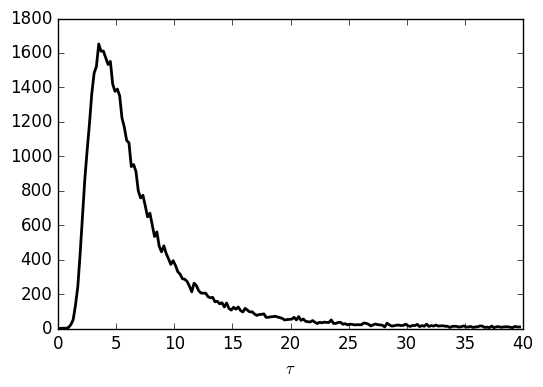

In [36]:
#draw posterior density of tau p(tau|y)
fig = plt.figure()
ax = fig.add_subplot(111)
taugrid = np.arange(0,40,0.2)
taucenter = (taugrid[:-1]+taugrid[1:])/2.0
htau,xedge = np.histogram(tau_d, bins=taugrid)
ax.plot(taucenter,htau,'k',linewidth=2)
ax.set_xlabel(r'$\tau$',fontsize=12)
fig.show()

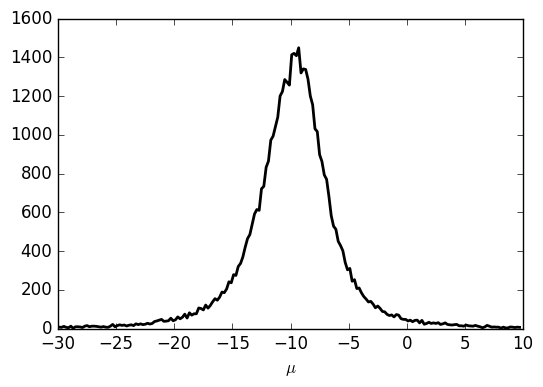

In [37]:
#draw posterior density of mu p(mu|tau,y)
fig = plt.figure()
ax = fig.add_subplot(111)
mugrid = np.arange(-30,10,0.2)
mucenter = (mugrid[:-1]+mugrid[1:])/2.0
hmu,xedge = np.histogram(mu_d, bins=mugrid)
ax.plot(mucenter,hmu,'k',linewidth=2)
ax.set_xlabel(r'$\mu$',fontsize=12)
fig.show()

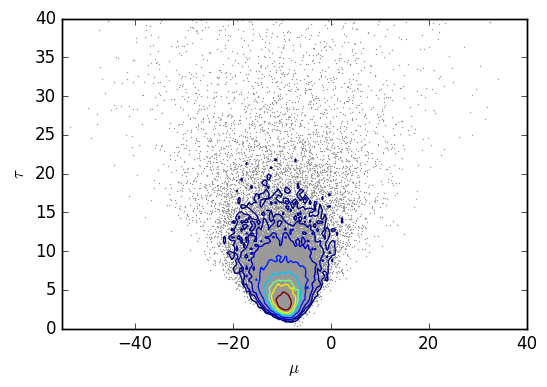

In [84]:
#draw joint posterior density of mu p(mu,tau|y)
taugrid2 = np.arange(0,40,0.5)
taucenter2 = (taugrid2[:-1]+taugrid2[1:])/2.0
mugrid2 = np.arange(-30,10,0.5)
mucenter2 = (mugrid2[:-1]+mugrid2[1:])/2.0
mumesh,taumesh = np.meshgrid(mucenter2, taucenter2)
mp,xedge,ydge = np.histogram2d(mu_d.reshape((N,)), \
        tau_d.reshape((N,)), bins=[mugrid2, taugrid2])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mu_d,tau_d,'.',\
        markeredgecolor=[0.6,0.6,0.6],\
        markerfacecolor=[0.6,0.6,0.6],\
       markersize=1)
ax1 = ax.twinx()
ax1.contour(mumesh, taumesh, mp.T, \
    levels=np.array([5,10,20,50,100,150,200,300]))
ax1.set_xlim([-55,40])
ax1.set_ylim([0,40])
ax1.set_yticklabels([])
ax.set_xlim([-55,40])
ax1.set_ylim([0,40])

ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'$\tau$',fontsize=12)
fig.show()

/Users/cliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars
/Users/cliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/cliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars
/Users/cliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars


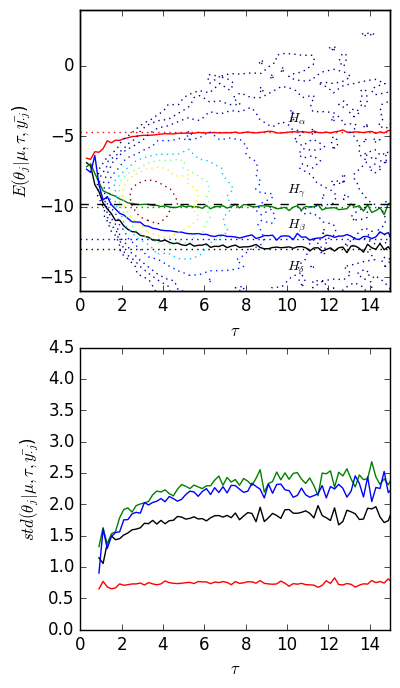

In [98]:
#sample theta_j from p(theta_j|mu,tao,y)
def draw_post_theta_j(mu,tau,y_bar_j,sigma2_j):
    V_j = 1/(1/sigma2_j+1/tau**2)
    theta_j_hat = (y_bar_j/sigma2_j+mu/tau**2)*V_j
    theta_j = np.random.normal(theta_j_hat, np.sqrt(V_j))
    return theta_j

theta_delta = draw_post_theta_j(mu_d,tau_d,y_bar[0],sigma2[0])
theta_gamma = draw_post_theta_j(mu_d,tau_d,y_bar[1],sigma2[1])
theta_beta = draw_post_theta_j(mu_d,tau_d,y_bar[2],sigma2[2])
theta_alpha = draw_post_theta_j(mu_d,tau_d,y_bar[3],sigma2[3])

E_theta_delta = np.zeros(np.shape(taucenter))
E_theta_gamma = np.zeros(np.shape(taucenter))
E_theta_beta = np.zeros(np.shape(taucenter))
E_theta_alpha = np.zeros(np.shape(taucenter))

D_theta_delta = np.zeros(np.shape(taucenter))
D_theta_gamma = np.zeros(np.shape(taucenter))
D_theta_beta = np.zeros(np.shape(taucenter))
D_theta_alpha = np.zeros(np.shape(taucenter))

for t in range(len(taucenter)):
    ind = (tau_d>taugrid[t]) & (tau_d<=taugrid[t+1])
    E_theta_delta[t] = np.mean(theta_delta[ind])
    E_theta_gamma[t] = np.mean(theta_gamma[ind])
    E_theta_beta[t] = np.mean(theta_beta[ind])
    E_theta_alpha[t] = np.mean(theta_alpha[ind])
    
    D_theta_delta[t] = np.sum((theta_delta[ind]-E_theta_delta[t])**2)/(np.sum(ind)-1)
    D_theta_gamma[t] = np.sum((theta_gamma[ind]-E_theta_gamma[t])**2)/(np.sum(ind)-1)
    D_theta_beta[t] = np.sum((theta_beta[ind]-E_theta_beta[t])**2)/(np.sum(ind)-1)
    D_theta_alpha[t] = np.sum((theta_alpha[ind]-E_theta_alpha[t])**2)/(np.sum(ind)-1)

taumesh,mumesh = np.meshgrid(taucenter2, mucenter2)
mp,xedge,ydge = np.histogram2d(tau_d.reshape((N,)), \
        mu_d.reshape((N,)), bins=[taugrid2, mugrid2])
fig = plt.figure(figsize=[4,8])
#mean_theta as a function of tau
ax = fig.add_subplot(211)
ax.plot(taucenter, E_theta_delta, 'k-')
ax.plot(taucenter, E_theta_gamma, 'g-')
ax.plot(taucenter, E_theta_beta, 'b-')
ax.plot(taucenter, E_theta_alpha, 'r-')
ax.plot([0,40], [y_bar[0],y_bar[0]], 'k:')
ax.plot([0,40], [y_bar[1],y_bar[1]], 'g:')
ax.plot([0,40], [y_bar[2],y_bar[2]], 'b:')
ax.plot([0,40], [y_bar[3],y_bar[3]], 'r:')
ax.plot([0,40],[np.mean(mu_d),np.mean(mu_d)],'k--')
ax1 = ax.twinx()
ax1.contour(taumesh,mumesh, mp.T, \
    levels=np.array([5,10,20,50,100,150,200,300]),\
           linestyles='dotted')
ax.text(10,-4,r'$H_\alpha$',fontsize=10)
ax.text(10,-9,r'$H_\gamma$',fontsize=10)
ax.text(10,-11.5,r'$H_\beta$',fontsize=10)
ax.text(10,-14.5,r'$H_\delta$',fontsize=10)
ax1.set_xlim([0,15])
ax1.set_ylim([-16,4])
ax1.set_yticklabels([])
ax.set_xlim([0,15])
ax.set_ylim([-16,4])
ax.set_xlabel(r'$\tau$',fontsize=12)
ax.set_ylabel(r'$E(\theta_j|\mu,\tau,\bar{y_{\cdot j}}$)',\
              fontsize=12)

#std. deviation of theta as a function of tau
ax = fig.add_subplot(212)
ax.plot(taucenter, np.sqrt(D_theta_delta), 'k-')
ax.plot(taucenter, np.sqrt(D_theta_gamma), 'g-')
ax.plot(taucenter, np.sqrt(D_theta_beta), 'b-')
ax.plot(taucenter, np.sqrt(D_theta_alpha), 'r-')

ax.set_xlim([0,15])
ax.set_xlabel(r'$\tau$',fontsize=12)
ax.set_ylabel(r'$std(\theta_j|\mu,\tau,\bar{y_{\cdot j}}$)',\
              fontsize=12)
fig.show()

In [91]:
print mumesh

[[-29.75 -29.25 -28.75 ...,   8.25   8.75   9.25]
 [-29.75 -29.25 -28.75 ...,   8.25   8.75   9.25]
 [-29.75 -29.25 -28.75 ...,   8.25   8.75   9.25]
 ..., 
 [-29.75 -29.25 -28.75 ...,   8.25   8.75   9.25]
 [-29.75 -29.25 -28.75 ...,   8.25   8.75   9.25]
 [-29.75 -29.25 -28.75 ...,   8.25   8.75   9.25]]
